In [1]:
import numpy as np
import pandas as pd
import json
import scipy.stats
import time

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

In [3]:
# this computes the three homogeneous learning curves of the three pure forest types
def get_learning_curves(result_row):
    
    # collect data
    sizes = []
    lcs_valid = []
    lcs_test = []
    for size, results_for_size in result_row.items():
        
        s = int(size)
        sizes.append(s)
        index1 = results_for_size[0].index([s, 0, 0])
        index2 = results_for_size[0].index([0, s, 0])
        index3 = results_for_size[0].index([0, 0, s])
        lcs_valid.append(tuple([results_for_size[1][i][0] for i in [index1, index2, index3]]))
        lcs_test.append(tuple([results_for_size[1][i][1] for i in [index1, index2, index3]]))
    return sizes, lcs_valid, lcs_test

In [4]:
df_results = pd.read_csv("results.csv", delimiter=";")

In [5]:
df_results = df_results[(df_results["results"].notna()) & (df_results["results"] != "[]")]

In [6]:
datasets = sorted(pd.unique(df_results["openmlid"]))
len(datasets)

96

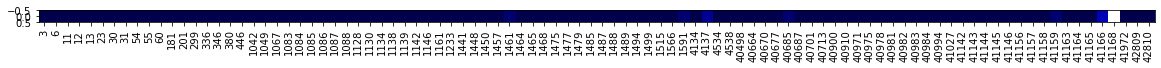

In [7]:
Z = np.zeros((1, len(datasets)))
for j, openmlid in enumerate(datasets):
    Z[0,j] = len(df_results[df_results["openmlid"] == openmlid])
fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(-Z, cmap="seismic", vmin=-20, vmax=0)
ax.set_xticks(range(len(datasets)))
ax.set_xticklabels(datasets, rotation=90)
plt.show()

In [8]:
df_results

,experiment_id,openmlid,seed,cpus,memory_max,time_created,host,executor,time_started,results,exception,time_end
0,1,60,0,4,16000,2022-02-10 13:53:54,node10-043,oculus-10848840-235,2022-02-17 19:17:00,"{""scores"": {""1"": [[[0, 0, 1], [0, 1, 0], [1, 0...",NaN,2022-02-17 19:51:54
1,2,60,1,4,16000,2022-02-10 13:53:54,node04-039,oculus-10848840-84,2022-02-17 19:17:00,"{""scores"": {""1"": [[[0, 0, 1], [0, 1, 0], [1, 0...",NaN,2022-02-17 19:47:21
2,3,11,0,4,16000,2022-02-10 13:53:54,node09-042,oculus-10848840-194,2022-02-17 19:17:00,"{""scores"": {""1"": [[[0, 0, 1], [0, 1, 0], [1, 0...",NaN,2022-02-17 19:19:14
3,4,11,1,4,16000,2022-02-10 13:53:54,node09-043,oculus-10848840-198,2022-02-17 19:17:01,"{""scores"": {""1"": [[[0, 0, 1], [0, 1, 0], [1, 0...",NaN,2022-02-17 19:19:13
4,5,13,0,4,16000,2022-02-10 13:53:54,node03-029,oculus-10848840-65,2022-02-17 19:17:01,"{""scores"": {""1"": [[[0, 0, 1], [0, 1, 0], [1, 0...",NaN,2022-02-17 19:19:01
...,...,...,...,...,...,...,...,...,...,...,...,...
2304,2355,42809,18,4,16000,2022-02-18 03:41:25,node08-047,oculus-10849970-242,2022-02-18 21:15:19,"{""scores"": {""1"": [[[0, 0, 1], [0, 1, 0], [1, 0...",NaN,2022-02-18 23:19:26
2305,2356,42810,17,4,16000,2022-02-18 03:41:25,node02-036,oculus-10849970-205,2022-02-18 21:39:24,"{""scores"": {""1"": [[[0, 0, 1], [0, 1, 0], [1, 0...",NaN,2022-02-19 10:34:03
2307,2358,42810,18,4,16000,2022-02-18 03:41:25,node08-031,oculus-10849970-178,2022-02-18 20:44:25,"{""scores"": {""1"": [[[0, 0, 1], [0, 1, 0], [1, 0...",NaN,2022-02-19 09:31:51
2308,2359,42809,19,4,16000,2022-02-18 03:41:25,node10-009,oculus-10849970-168,2022-02-18 21:26:51,"{""scores"": {""1"": [[[0, 0, 1], [0, 1, 0], [1, 0...",NaN,2022-02-18 23:27:11


In [9]:
def compute_learning_curve_frame(df):
    rows = []
    for i, row in tqdm(df.sort_values("openmlid").iterrows()):
        result = json.loads(row["results"])
        if type(result) == dict:
            sizes, lcs_valid, lcs_test = get_learning_curves(result["scores"])
            lc_valid_rf = [np.round(e[0], 4) for e in lcs_valid]
            lc_valid_lda = [np.round(e[1], 4) for e in lcs_valid]
            lc_valid_pca = [np.round(e[2], 4) for e in lcs_valid]
            lc_test_rf = [np.round(e[0], 4) for e in lcs_test]
            lc_test_lda = [np.round(e[1], 4) for e in lcs_test]
            lc_test_pca = [np.round(e[2], 4) for e in lcs_test]
            for j, size in enumerate(sizes):
                train_time_rf = sum(result["times"][0][:size])
                train_time_lda = sum(result["times"][1][:size])
                train_time_pca = sum(result["times"][2][:size])
                rows.append([row["openmlid"], row["seed"], size, train_time_rf, train_time_lda, train_time_pca, lc_valid_rf[j], lc_valid_lda[j], lc_valid_pca[j], lc_test_rf[j], lc_test_lda[j], lc_test_pca[j]])
        else:
            print(f"Ignoring invalid row for dataset {row['openmlid']}")
    return pd.DataFrame(rows, columns=["openmlid", "seed", "size", "train_time_rf", "train_time_lda", "train_time_pca", "lc_rf_oob", "lc_lda_oob", "lc_pca_oob", "lc_rf_test", "lc_lda_test", "lc_pca_test"])

df_benchmark = compute_learning_curve_frame(df_results)

0it [00:00, ?it/s]

In [10]:
df_benchmark.to_csv("benchmark.csv", index = False)